In [1]:
# Library loading
%matplotlib inline

import pandas as pd # manipulate dataframes
import matplotlib.pyplot as plt # plotting
import matplotlib
import numpy as np
import time

from sklearn.metrics import mean_squared_error
import h5py

# Check torch install
try:
  import torch
except:
  print("Starting a session, torch not installed, installing...")
  !pip3 install torch # we install torch if not installed
  import torch

# First we check if CUDA is available
print("CUDA AVAILABLE? ",torch.cuda.is_available())

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
      
device = get_default_device()
print(device)


from torch.autograd import Variable

CUDA AVAILABLE?  True
cuda


# Load data and run on device

data are available through a data loader Pytorch

In [2]:
# load neuravi
import neuravi

### Load dataset
ds = neuravi.data_loader("./data/DataSet_0p80val.hdf5",
                         "./data/NKAS_Raman.hdf5",
                         "./data/NKAS_density.hdf5",
                         "./data/NKAS_optical.hdf5",device)

# savepath
savepath = "./model/model.pth"

/home/charles/anaconda3/envs/ml/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


# GAN creation

Now we create two networks, the **D**ectective and **G**enerative networks.

**G**net is basically the one I used to use for "normal" networks. I thus use the model class already defined in `neuravi.model`.

**D**net will be different as it aims at classifying fake and real data. It will take all the observations in input (Raman, viscosity, etc.) and say if they are true or false... 


In [60]:
class Dnet(torch.nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, p_drop=0.5):
        super(Dnet, self).__init__()

        # init parameters
        self.input_size = input_size
        self.hidden_size  = hidden_size
        self.num_layers  = num_layers

        # network related torch stuffs
        self.relu = torch.nn.ReLU()
        self.sigmoid = torch.nn.Sigmoid()
        self.dropout = torch.nn.Dropout(p=p_drop)

        self.linears = torch.nn.ModuleList([torch.nn.Linear(input_size, self.hidden_size)])
        self.linears.extend([torch.nn.Linear(self.hidden_size, self.hidden_size) for i in range(1, self.num_layers)])

        self.out = torch.nn.Linear(self.hidden_size, 1) # Linear output

    def forward(self, x):
        """core neural network with sigmoid layers"""
        # Feedforward
        for layer in self.linears:
            x = self.dropout(self.relu(layer(x)))
        return self.sigmoid(self.out(x))
       

We also need a function to generate fake data:

In [61]:
def extract(v):
    return v.data.storage().tolist()

def gi_generate_x(nb_samples):

    sio2_gen = np.random.random_sample(nb_samples)*0.5 + 0.5

    reminder = 1.0 - sio2_gen

    R_MAl = np.random.random_sample(nb_samples)*(1.0-0.4) + 0.4 # ratio of alkalis to Al

    R_XK = np.random.random_sample(nb_samples) # ratio K/(K+Na)

    al2o3_gen = (1.0 - R_MAl)*reminder

    reminder = 1 - sio2_gen - al2o3_gen

    na2o_gen = reminder*(1.0-R_XK)
    k2o_gen = 1 - sio2_gen - al2o3_gen - na2o_gen

    Temp = torch.Tensor(np.random.random_sample(nb_samples)*2500)+500
    
    lbd = np.random.random_sample(nb_samples)*1.5 + 0.001
    
    return torch.Tensor(np.vstack([sio2_gen,al2o3_gen,na2o_gen,k2o_gen]).T).to(device),torch.reshape(Temp, (Temp.shape[0], 1)).to(device)

# Now let's create the networks

In [97]:
# Generative Network declaration
G_ = neuravi.model(4,100,4,ds.nb_channels_raman,p_drop=0.0) 

# we initialize the output bias
G_.output_bias_init()

#Detective network declaration
D_ = Dnet(6,100,4, p_drop=0)

# criterion for match
criterion_MSE = torch.nn.MSELoss()
criterion_MSE.to(device)

criterion_classi = torch.nn.BCELoss()  # Binary cross entropy: http://pytorch.org/docs/nn.html#bceloss
criterion_classi.to(device)

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

optimizer_G = torch.optim.Adam(G_.parameters(), lr = 0.0002, betas=(beta1, 0.999)) # optimizer
optimizer_D = torch.optim.Adam(D_.parameters(), lr = 0.0002, betas=(beta1, 0.999)) # optimizer

# we send the neural net on device
G_.to(device)
D_.to(device)

Dnet(
  (relu): ReLU()
  (sigmoid): Sigmoid()
  (dropout): Dropout(p=0, inplace=False)
  (linears): ModuleList(
    (0): Linear(in_features=6, out_features=100, bias=True)
    (1): Linear(in_features=100, out_features=100, bias=True)
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): Linear(in_features=100, out_features=100, bias=True)
  )
  (out): Linear(in_features=100, out_features=1, bias=True)
)

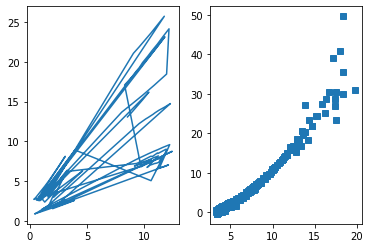

In [98]:
plt.subplot(1,2,1)
plt.plot(ds.y_visco_train.cpu().detach().numpy(),G_.ag(ds.x_visco_train,ds.T_visco_train).cpu().detach().numpy())

plt.subplot(1,2,2)
d_Xgen_input, d_Tgen_input = gi_generate_x(b_size)
plt.plot(10000/d_Tgen_input.cpu().detach().numpy(),G_.ag(d_Xgen_input,d_Tgen_input).cpu().detach().numpy(),"s")

In [99]:
# To see how the model is improving, 
# we can check the test loss before the model training and compare it with the test loss after the training.
G_.eval()

y_ag_pred_train = G_.ag(ds.x_visco_train,ds.T_visco_train)
y_ag_pred_valid = G_.ag(ds.x_visco_valid,ds.T_visco_valid)

y_ri_pred_train = G_.sellmeier(ds.x_ri_train,ds.lbd_ri_train)
y_ri_pred_valid = G_.sellmeier(ds.x_ri_valid,ds.lbd_ri_valid)

ag_before_train = criterion_MSE(y_ag_pred_train, ds.y_visco_train)
ag_before_valid = criterion_MSE(y_ag_pred_valid, ds.y_visco_valid)
print('Train loss before training' , ag_before_train.item())
print('Valid loss before training' , ag_before_valid.item())

ri_before_train = criterion_MSE(y_ri_pred_train, ds.y_ri_train)
ri_before_valid = criterion_MSE(y_ri_pred_valid, ds.y_ri_valid)
print('Train loss before training' , ri_before_train.item())
print('Valid loss before training' , ri_before_valid.item())

G_

Train loss before training 14.135847091674805
Valid loss before training 22.105344772338867
Train loss before training 0.0020822654478251934
Valid loss before training 0.001429739291779697


model(
  (relu): ReLU()
  (dropout): Dropout(p=0.0, inplace=False)
  (linears): ModuleList(
    (0): Linear(in_features=4, out_features=100, bias=True)
    (1): Linear(in_features=100, out_features=100, bias=True)
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): Linear(in_features=100, out_features=100, bias=True)
  )
  (out_thermo): Linear(in_features=100, out_features=15, bias=True)
  (out_raman): Linear(in_features=100, out_features=850, bias=True)
)

In [100]:
# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

num_epochs = 10000
print_interval = 500

d_steps = 20
g_steps = 20

minibatch_size = 50

G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
        
        # 1. Train D on real+fake
        D_.zero_grad()

        #  1A: Train D on real         
        d_real_data = torch.cat((ds.x_visco_train, ds.T_visco_train,ds.y_visco_train), 1)
        output = D_(d_real_data)
        b_size = output.size(0)
        label = torch.full((b_size,), real_label, device=device)
        d_real_error = criterion_classi(output, label) 
        d_real_error.backward() # compute/store gradients, but don't change params

        #  1B: Train D on fake
        d_Xgen_input, d_Tgen_input = gi_generate_x(b_size)
        # Generate fake image batch with G
        fake_data = torch.cat((d_Xgen_input, d_Tgen_input,G_.ag(d_Xgen_input,d_Tgen_input)), 1)
        label.fill_(fake_label) 
        # Classify all fake batch with D
        output = D_(fake_data.detach())
        d_fake_error = criterion_classi(output,label)  
        d_fake_error.backward()
        optimizer_D.step()     # Only optimizes D's parameters; changes based on stored gradients from backward()

        errD = d_real_error + d_fake_error

        
        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        G_.zero_grad()
        label.fill_(real_label) 
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = D_(fake_data)
        # Calculate G's loss based on this output
        errG = criterion_classi(output, label)
        # Calculate gradients for G
        errG.backward()
        optimizer_G.step()  # Only optimizes G's parameters

        if epoch % print_interval == 0:
            print("Epoch %s: D (%s real_err, %s fake_err) G (%s err)) " %
                  (epoch, d_real_error.item(), d_fake_error.item(), errG.item()))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())



Starting Training Loop...
Epoch 0: D (0.2010970413684845 real_err, 2.062883138656616 fake_err) G (2.347787380218506 err)) 
Epoch 500: D (0.8211389183998108 real_err, 0.5507546663284302 fake_err) G (0.718724250793457 err)) 
Epoch 1000: D (0.8934381008148193 real_err, 0.4757424294948578 fake_err) G (0.6939048767089844 err)) 
Epoch 1500: D (0.6353093981742859 real_err, 0.7293463349342346 fake_err) G (0.9152552485466003 err)) 
Epoch 2000: D (0.7837206721305847 real_err, 0.5693759322166443 fake_err) G (0.7095664143562317 err)) 
Epoch 2500: D (0.6858847141265869 real_err, 0.6623879075050354 fake_err) G (0.7722551226615906 err)) 
Epoch 3000: D (0.7645711302757263 real_err, 0.5630360245704651 fake_err) G (0.7438569068908691 err)) 
Epoch 3500: D (0.7074580788612366 real_err, 0.635981559753418 fake_err) G (0.7642859816551208 err)) 
Epoch 4000: D (0.6560287475585938 real_err, 0.679955005645752 fake_err) G (0.8047272562980652 err)) 
Epoch 4500: D (0.593542754650116 real_err, 0.7608431577682495 fak

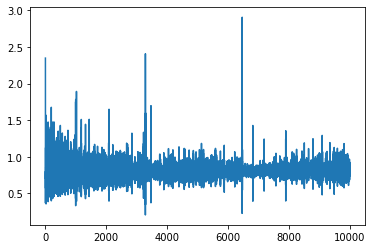

In [101]:
plt.plot(G_losses)

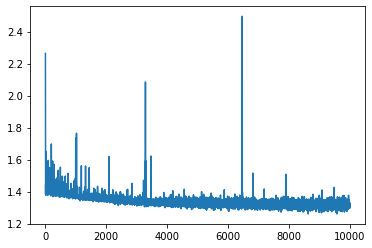

In [102]:
plt.plot(D_losses)

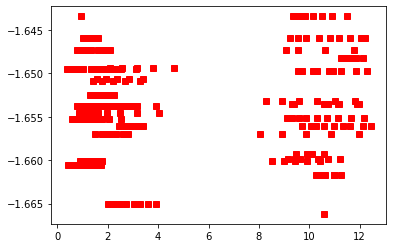

In [103]:
plt.plot(ds.y_visco_train.cpu().detach().numpy(),G_.am(ds.x_visco_train,ds.T_visco_train).cpu().detach().numpy(),'rs')



# Pretraining!

! Pretrain mode...

Epoch 0 => train loss: 70.6301498413086; valid loss: 78.34495544433594
Running time in seconds: 6.974118947982788


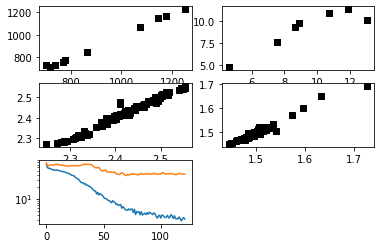

In [3]:
neuralmodel, record_pretrain_loss, record_prevalid_loss = neuravi.training(neuralmodel,ds,
                                                                           criterion,optimizer,savepath,mode="pretrain")

neuralmodel.eval() # putting the network in eval mode and looking at pretrained training results

plt.subplot(3,2,1)
plt.plot(ds.y_tg_train.cpu().detach().numpy(),neuralmodel.tg(ds.x_tg_train).cpu().detach().numpy(),"ks",label="Train")

plt.subplot(3,2,2)
plt.plot(ds.y_entro_train.cpu().detach().numpy(),neuralmodel.sctg(ds.x_entro_train).cpu().detach().numpy(),"ks")

plt.subplot(3,2,3)
plt.plot(ds.y_density_train.cpu().detach().numpy(),neuralmodel.density(ds.x_density_train).cpu().detach().numpy(),"ks")

plt.subplot(3,2,4)
plt.plot(ds.y_ri_train.cpu().detach().numpy(),neuralmodel.sellmeier(ds.x_ri_train,ds.lbd_ri_train).cpu().detach().numpy(),"ks")


plt.subplot(3,2,5)
plt.plot(record_pretrain_loss)
plt.plot(record_prevalid_loss)
plt.yscale('log')

In [4]:
y_ri_pred_train = neuralmodel.sellmeier(ds.x_ri_train,ds.lbd_ri_train)
y_ri_pred_valid = neuralmodel.sellmeier(ds.x_ri_valid,ds.lbd_ri_valid)

ag_before_train = criterion(y_ag_pred_train, ds.y_visco_train)
ag_before_valid = criterion(y_ag_pred_valid, ds.y_visco_valid)
print('Train loss before training' , ag_before_train.item())
print('Valid loss before training' , ag_before_valid.item())

ri_before_train = criterion(y_ri_pred_train, ds.y_ri_train)
ri_before_valid = criterion(y_ri_pred_valid, ds.y_ri_valid)
print('Train loss before training' , ri_before_train.item())
print('Valid loss before training' , ri_before_valid.item())


Train loss before training 20.18556785583496
Valid loss before training 30.863584518432617
Train loss before training 3.449188079684973e-05
Valid loss before training 4.205972436466254e-05


In [5]:
neuralmodel.ag(ds.x_visco_train,ds.T_visco_train).cpu().detach().numpy()

array([[ 8.520515  ],
       [ 8.919319  ],
       [ 9.346773  ],
       [ 9.805907  ],
       [10.300178  ],
       [ 2.4301305 ],
       [ 2.2517967 ],
       [ 2.087278  ],
       [ 1.935095  ],
       [ 1.7939667 ],
       [ 1.6627792 ],
       [ 1.1389108 ],
       [ 1.2637272 ],
       [ 1.399189  ],
       [ 1.5466409 ],
       [ 1.7076564 ],
       [ 1.8840847 ],
       [ 2.078121  ],
       [ 2.2923813 ],
       [ 9.393965  ],
       [ 9.566146  ],
       [ 9.773111  ],
       [10.049315  ],
       [10.403306  ],
       [10.707274  ],
       [11.061261  ],
       [11.47185   ],
       [11.865914  ],
       [11.6017475 ],
       [10.8162985 ],
       [10.107196  ],
       [ 9.464347  ],
       [ 8.879321  ],
       [ 3.7507362 ],
       [ 3.4669924 ],
       [ 3.2078738 ],
       [ 2.970467  ],
       [ 2.7522907 ],
       [ 2.551217  ],
       [ 2.3654156 ],
       [11.434235  ],
       [10.707582  ],
       [10.046236  ],
       [ 9.737509  ],
       [ 2.225987  ],
       [ 1

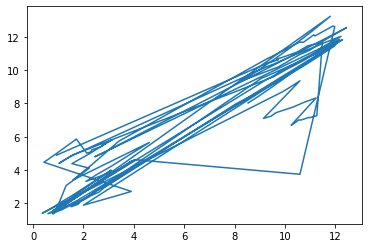

In [6]:
plt.plot(ds.y_visco_train.cpu().detach().numpy(), neuralmodel.cg(ds.x_visco_train,ds.T_visco_train).cpu().detach().numpy())

# Training

In [7]:
neuralmodel, record_train_loss, record_valid_loss = neuravi.training(neuralmodel,
                                                                         ds,
                                                                         criterion,optimizer,
                                                                         savepath,verbose=True,
                                                                         train_patience=50)

Full training.

Epoch 0 => train loss: 14.197381019592285; valid loss: 26.950294494628906
Epoch 200 => train loss: 2.054056167602539; valid loss: 10.059420585632324
Running time in seconds: 25.423625707626343


# Loss function plot

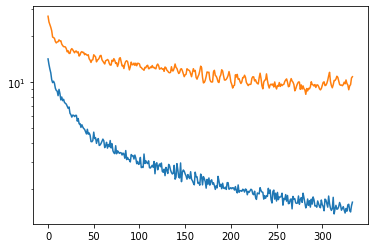

In [8]:
plt.plot(record_train_loss)
plt.plot(record_valid_loss)
plt.yscale('log')

# upload on Google Drive
#file_out = drive.CreateFile()
# Read file and set it as a content of this instance.
#file_out.SetContentFile("model.pth")
#file_out.Upload() # Upload the file.

# Post-training evaluations

In [9]:
neuralmodel.eval()
y_ag_train = neuralmodel.ag(ds.x_visco_train,ds.T_visco_train)
y_ag_valid = neuralmodel.ag(ds.x_visco_valid,ds.T_visco_valid)
y_ag_test = neuralmodel.ag(ds.x_visco_test,ds.T_visco_test)

y_myega_train = neuralmodel.myega(ds.x_visco_train,ds.T_visco_train)
y_myega_valid = neuralmodel.myega(ds.x_visco_valid,ds.T_visco_valid)
y_myega_test = neuralmodel.myega(ds.x_visco_test,ds.T_visco_test)

y_am_train = neuralmodel.am(ds.x_visco_train,ds.T_visco_train)
y_am_valid = neuralmodel.am(ds.x_visco_valid,ds.T_visco_valid)
y_am_test = neuralmodel.am(ds.x_visco_test,ds.T_visco_test)

y_cg_train = neuralmodel.cg(ds.x_visco_train,ds.T_visco_train)
y_cg_valid = neuralmodel.cg(ds.x_visco_valid,ds.T_visco_valid)
y_cg_test = neuralmodel.cg(ds.x_visco_test,ds.T_visco_test)

ag_after_train = criterion(y_ag_train, ds.y_visco_train)
ag_after_valid = criterion(y_ag_valid, ds.y_visco_valid)
ag_after_test = criterion(y_ag_test, ds.y_visco_test)
print('AG train loss after training' , ag_after_train.item())
print('AG valid loss after training' , ag_after_valid.item())
print('AG test loss after training' , ag_after_test.item())
print('')
myega_after_train = criterion(y_myega_train, ds.y_visco_train)
myega_after_valid = criterion(y_myega_valid, ds.y_visco_valid)
myega_after_test = criterion(y_myega_test, ds.y_visco_test)
print('MYEGA train loss after training' , myega_after_train.item())
print('MYEGA valid loss after training' , myega_after_valid.item())
print('MYEGA test loss after training' , myega_after_test.item())
print('')
am_after_train = criterion(y_am_train, ds.y_visco_train)
am_after_valid = criterion(y_am_valid, ds.y_visco_valid)
am_after_test = criterion(y_am_test, ds.y_visco_test)
print('am train loss after training' , am_after_train.item())
print('am valid loss after training' , am_after_valid.item())
print('am test loss after training' , am_after_test.item())
print('')
cg_after_train = criterion(y_cg_train, ds.y_visco_train)
cg_after_valid = criterion(y_cg_valid, ds.y_visco_valid)
cg_after_test = criterion(y_cg_test, ds.y_visco_test)
print('CG train loss after training' , cg_after_train.item())
print('CG valid loss after training' , cg_after_valid.item())
print('CG test loss after training' , cg_after_test.item())

AG train loss after training 0.06757304817438126
AG valid loss after training 1.3826582431793213
AG test loss after training 0.5664257407188416

MYEGA train loss after training 0.062099527567625046
MYEGA valid loss after training 1.5590453147888184
MYEGA test loss after training 0.5561955571174622

am train loss after training 0.04565979167819023
am valid loss after training 1.5225539207458496
am test loss after training 0.5841712355613708

CG train loss after training 0.05953778326511383
CG valid loss after training 1.8649336099624634
CG test loss after training 0.5880133509635925


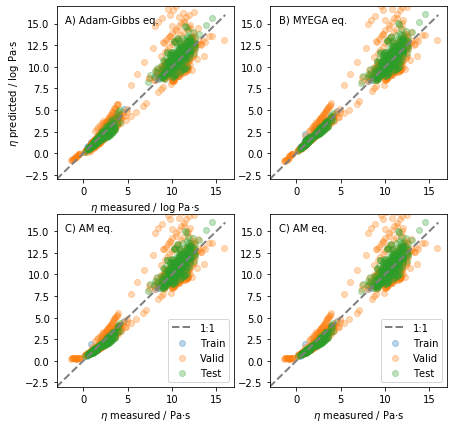

In [10]:
plt.figure(figsize=(7,7))

plt.subplot(2,2,1)
plt.scatter(ds.y_visco_train.cpu().detach().numpy(),y_ag_train.cpu().detach().numpy(),alpha=0.3,label="Train")
plt.scatter(ds.y_visco_valid.cpu().detach().numpy(),y_ag_valid.cpu().detach().numpy(),alpha=0.3,label="Valid")
plt.scatter(ds.y_visco_test.cpu().detach().numpy(),y_ag_test.cpu().detach().numpy(),alpha=0.3,label="Test")

plt.plot([-3,16],[-3,16],"--",color="grey",linewidth=2)

plt.xlim(-3,17)
plt.ylim(-3,17)

plt.xlabel("$\eta$ measured / log Pa$\cdot$s")
plt.ylabel("$\eta$ predicted / log Pa$\cdot$s")

plt.annotate("A) Adam-Gibbs eq.",xy=(0.05,0.9),xycoords="axes fraction",ha="left")

#plt.legend(loc=4)

plt.subplot(2,2,2)
plt.scatter(ds.y_visco_train.cpu().detach().numpy(),y_myega_train.cpu().detach().numpy(),alpha=0.3,label="Train")
plt.scatter(ds.y_visco_valid.cpu().detach().numpy(),y_myega_valid.cpu().detach().numpy(),alpha=0.3,label="Valid")
plt.scatter(ds.y_visco_test.cpu().detach().numpy(),y_myega_test.cpu().detach().numpy(),alpha=0.3,label="Test")

plt.plot([-3,16],[-3,16],"--",color="grey",linewidth=2,label="1:1")

plt.xlim(-3,17)
plt.ylim(-3,17)

plt.annotate("B) MYEGA eq.",xy=(0.05,0.9),xycoords="axes fraction",ha="left")

plt.subplot(2,2,3)
plt.scatter(ds.y_visco_train.cpu().detach().numpy(),y_am_train.cpu().detach().numpy(),alpha=0.3,label="Train")
plt.scatter(ds.y_visco_valid.cpu().detach().numpy(),y_am_valid.cpu().detach().numpy(),alpha=0.3,label="Valid")
plt.scatter(ds.y_visco_test.cpu().detach().numpy(),y_am_test.cpu().detach().numpy(),alpha=0.3,label="Test")

plt.plot([-3,16],[-3,16],"--",color="grey",linewidth=2,label="1:1")

plt.xlim(-3,17)
plt.ylim(-3,17)

plt.annotate("C) AM eq.",xy=(0.05,0.9),xycoords="axes fraction",ha="left")

plt.legend(loc=4)

plt.xlabel("$\eta$ measured / Pa$\cdot$s")


plt.subplot(2,2,4)
plt.scatter(ds.y_visco_train.cpu().detach().numpy(),y_am_train.cpu().detach().numpy(),alpha=0.3,label="Train")
plt.scatter(ds.y_visco_valid.cpu().detach().numpy(),y_am_valid.cpu().detach().numpy(),alpha=0.3,label="Valid")
plt.scatter(ds.y_visco_test.cpu().detach().numpy(),y_am_test.cpu().detach().numpy(),alpha=0.3,label="Test")

plt.plot([-3,16],[-3,16],"--",color="grey",linewidth=2,label="1:1")

plt.xlim(-3,17)
plt.ylim(-3,17)

plt.annotate("C) AM eq.",xy=(0.05,0.9),xycoords="axes fraction",ha="left")

plt.legend(loc=4)

plt.xlabel("$\eta$ measured / Pa$\cdot$s")
plt.show()

<ErrorbarContainer object of 3 artists>

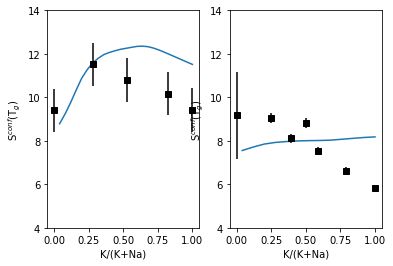

In [11]:
na2o = np.arange(0.,0.25,0.01)
k2o = 0.25-na2o
sio2 = np.ones(len(na2o))*0.75
al2o3 = np.zeros(len(na2o))

X_visu_ = np.vstack([sio2,al2o3,na2o,k2o]).T
X_visu_.shape

plt.subplot(1,2,1)
plt.plot(X_visu_[:,3]/(X_visu_[:,2]+X_visu_[:,3]),neuralmodel.sctg(torch.Tensor(X_visu_).to(device)).cpu().detach().numpy(),label="NN model")

plt.xlabel("K/(K+Na)")
plt.ylabel("S$^{conf}$(T$_g$)")
plt.ylim(4,14)

plt.errorbar(np.array([0,0.28,0.53,0.82,1.0]),np.array([32.91,40.31,37.81,35.59,32.99])/7.0*2.0,
    yerr = 1.0, fmt="ks",
    label="Richet, 1984")

plt.subplot(1,2,2)
na2o = np.arange(0.,0.125,0.01)
k2o = 0.125-na2o
sio2 = np.ones(len(na2o))*0.75
al2o3 = np.ones(len(na2o))*0.125

X_visu_ = np.vstack([sio2,al2o3,na2o,k2o]).T
X_visu_.shape

plt.plot(X_visu_[:,3]/(X_visu_[:,2]+X_visu_[:,3]),neuralmodel.sctg(torch.Tensor(X_visu_).to(device)).cpu().detach().numpy(),label="NN model")

plt.xlabel("K/(K+Na)")
plt.ylabel("S$^{conf}$(T$_g$)")
plt.ylim(4,14)

plt.errorbar(np.array([0,0.25,0.39,0.50,0.59,0.79,1.00]),
             np.array([9.17,9.06,8.12,8.84,7.54,6.63,5.83]),
    yerr = np.array([2.,0.23,0.20,0.23,0.18,0.15,0.11]), fmt="ks",
    label="Le Losq et al., 2017")

Checking shape...
(50, 4)


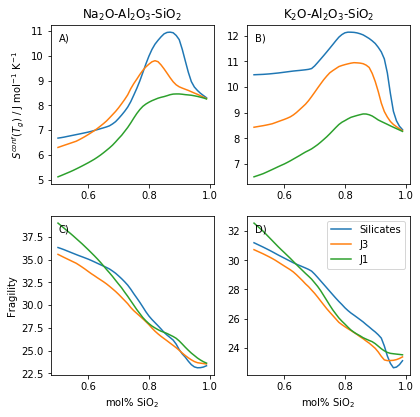

In [12]:
sio2 = np.arange(0.5,1.,0.01)

# order => sio2 al2o3 na2o k2o
X_visu_NAS_sili = np.vstack([sio2,np.zeros(len(sio2)),1.0-sio2,np.zeros(len(sio2))]).T
X_visu_NAS_J3 = np.vstack([sio2,(1.0-sio2)*1.0/3.0, (1.0-sio2)*2.0/3.0,np.zeros(len(sio2))]).T
X_visu_NAS_J1 = np.vstack([sio2,(1.0-sio2)*0.5, (1.0-sio2)*0.5,np.zeros(len(sio2))]).T

X_visu_KAS_sili = np.vstack([sio2,np.zeros(len(sio2)),np.zeros(len(sio2)),1.0-sio2]).T
X_visu_KAS_J3 = np.vstack([sio2,(1.0-sio2)*1.0/3.0,np.zeros(len(sio2)), (1.0-sio2)*2.0/3.0]).T
X_visu_KAS_J1 = np.vstack([sio2,(1.0-sio2)*0.5,np.zeros(len(sio2)), (1.0-sio2)*0.5]).T
print("Checking shape...")
print(X_visu_KAS_J1.shape)

plt.figure(figsize=(6.44,6.44))

plt.subplot(2,2,1) # NAS entropy

plt.plot(X_visu_NAS_sili[:,0],neuralmodel.sctg(torch.Tensor(X_visu_NAS_sili).to(device)).cpu().detach().numpy(),color="C0",label="Silicates")
plt.plot(X_visu_NAS_J3[:,0],neuralmodel.sctg(torch.Tensor(X_visu_NAS_J3).to(device)).cpu().detach().numpy(),color="C1",label="J3")
plt.plot(X_visu_NAS_J1[:,0],neuralmodel.sctg(torch.Tensor(X_visu_NAS_J1).to(device)).cpu().detach().numpy(),color="C2",label="J1")

plt.title(r"Na$_2$O-Al$_2$O$_3$-SiO$_2$")
plt.ylabel("$S^{conf}(T_g)$ / J mol$^{-1}$ K$^{-1}$")
plt.annotate("A)",xy=(0.05,0.9),xycoords="axes fraction",ha="left")


plt.subplot(2,2,2) # KAS entropy

plt.plot(X_visu_KAS_sili[:,0],neuralmodel.sctg(torch.Tensor(X_visu_KAS_sili).to(device)).cpu().detach().numpy(),color="C0",label="Silicates")
plt.plot(X_visu_KAS_J3[:,0],neuralmodel.sctg(torch.Tensor(X_visu_KAS_J3).to(device)).cpu().detach().numpy(),color="C1",label="J3")
plt.plot(X_visu_KAS_J1[:,0],neuralmodel.sctg(torch.Tensor(X_visu_KAS_J1).to(device)).cpu().detach().numpy(),color="C2",label="J1")

plt.title(r"K$_2$O-Al$_2$O$_3$-SiO$_2$")
plt.annotate("B)",xy=(0.05,0.9),xycoords="axes fraction",ha="left")

plt.subplot(2,2,3) # NAS fragility

plt.plot(X_visu_NAS_sili[:,0],neuralmodel.fragility(torch.Tensor(X_visu_NAS_sili).to(device)).cpu().detach().numpy(),color="C0",label="Silicates")
plt.plot(X_visu_NAS_J3[:,0],neuralmodel.fragility(torch.Tensor(X_visu_NAS_J3).to(device)).cpu().detach().numpy(),color="C1",label="J3")
plt.plot(X_visu_NAS_J1[:,0],neuralmodel.fragility(torch.Tensor(X_visu_NAS_J1).to(device)).cpu().detach().numpy(),color="C2",label="J1")

plt.xlabel("mol% SiO$_2$")
plt.ylabel("Fragility")
plt.annotate("C)",xy=(0.05,0.9),xycoords="axes fraction",ha="left")
#plt.ylim(17,60)

plt.subplot(2,2,4) # KAS fragility

plt.plot(X_visu_KAS_sili[:,0],neuralmodel.fragility(torch.Tensor(X_visu_KAS_sili).to(device)).cpu().detach().numpy(),color="C0",label="Silicates")
plt.plot(X_visu_KAS_J3[:,0],neuralmodel.fragility(torch.Tensor(X_visu_KAS_J3).to(device)).cpu().detach().numpy(),color="C1",label="J3")
plt.plot(X_visu_KAS_J1[:,0],neuralmodel.fragility(torch.Tensor(X_visu_KAS_J1).to(device)).cpu().detach().numpy(),color="C2",label="J1")
#plt.ylim(17,60)

plt.xlabel("mol% SiO$_2$")
plt.annotate("D)",xy=(0.05,0.9),xycoords="axes fraction",ha="left")

plt.legend(loc="upper right")

NameError: name 'y_tg_train' is not defined

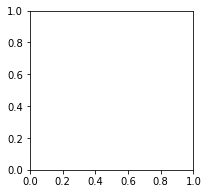

In [13]:
plt.figure(figsize=(6.44,6.44))

plt.subplot(2,2,1)
plt.plot(y_tg_train.cpu().detach().numpy(),neuralmodel.tg(x_tg_train).cpu().detach().numpy(),marker="s",linestyle="none",color="C0",alpha=0.3,label="Train")
plt.plot(y_tg_valid.cpu().detach().numpy(),neuralmodel.tg(x_tg_valid).cpu().detach().numpy(),"o",color="C1",alpha=0.3,label="Valid")
plt.plot(y_tg_test.cpu().detach().numpy(),neuralmodel.tg(x_tg_test).cpu().detach().numpy(),"d",color="C2",alpha=0.3,label="Test")

plt.ylabel("Predicted")
plt.title(r"A) $T_g$ / K")

plt.plot([600,1500],[600,1500],"--",color="grey",linewidth=2,label="1:1")

plt.legend(loc="upper left")

plt.subplot(2,2,2)
plt.plot(y_entro_train.cpu().detach().numpy(),neuralmodel.sctg(x_entro_train).cpu().detach().numpy(),"s",color="C0",alpha=0.3,label="Train")
plt.plot(y_entro_valid.cpu().detach().numpy(),neuralmodel.sctg(x_entro_valid).cpu().detach().numpy(),"o",color="C1",alpha=0.3,label="Valid")
plt.plot(y_entro_test.cpu().detach().numpy(),neuralmodel.sctg(x_entro_test).cpu().detach().numpy(),"o",color="C2",alpha=0.3,label="Test")

plt.title(r"C) $S^{conf}(T_g)$ / J mol$^{-1}$ K$^{-1}$")

plt.plot([4,12],[4,12],"--",color="grey",linewidth=2,label="1:1")

plt.subplot(2,2,3)
plt.plot(y_density_train.cpu().detach().numpy(),neuralmodel.density(x_density_train).cpu().detach().numpy(),"s",color="C0",alpha=0.3,label="Train")
plt.plot(y_density_valid.cpu().detach().numpy(),neuralmodel.density(x_density_valid).cpu().detach().numpy(),"o",color="C1",alpha=0.3,label="Valid")
plt.plot(y_density_test.cpu().detach().numpy(),neuralmodel.density(x_density_test).cpu().detach().numpy(),"o",color="C2",alpha=0.3,label="Test")

plt.xlabel("Measured")
plt.ylabel("Predicted")
plt.title(r"C) Density / g cm$^{-1}$")

plt.plot([2.1,2.7],[2.1,2.7],"--",color="grey",linewidth=2,label="1:1")

plt.subplot(2,2,4)

# Train
Cpconf = neuralmodel.ap_calc(x_visco_train) + neuralmodel.b_calc(x_visco_train)* neuralmodel.tg(x_visco_train)
Cp_S = Cpconf/neuralmodel.sctg(x_visco_train)
plt.plot(Cp_S.cpu().detach().numpy(),neuralmodel.fragility(x_visco_train).cpu().detach().numpy(),"s",color="C0",alpha=0.3,label="Train")

# Valid
Cpconf = neuralmodel.ap_calc(x_visco_valid) + neuralmodel.b_calc(x_visco_valid)* neuralmodel.tg(x_visco_valid)
Cp_S = Cpconf/neuralmodel.sctg(x_visco_valid)
plt.plot(Cp_S.cpu().detach().numpy(),neuralmodel.fragility(x_visco_valid).cpu().detach().numpy(),"o",color="C1",alpha=0.3,label="Valid")

# Test
Cpconf = neuralmodel.ap_calc(x_visco_test) + neuralmodel.b_calc(x_visco_test)* neuralmodel.tg(x_visco_test)
Cp_S = Cpconf/neuralmodel.sctg(x_visco_test)
plt.plot(Cp_S.cpu().detach().numpy(),neuralmodel.fragility(x_visco_test).cpu().detach().numpy(),"d",color="C2",alpha=0.3,label="test")

plt.xlabel(r"$Cp^{conf}(T_g)/S^{conf}(T_g)$")
plt.ylabel("fragility")

plt.title(r"D) $A_{e}$ / Pa$\cdot$s")

plt.xlim(0,3)
plt.ylim(15,50)

plt.legend()

plt.tight_layout()

In [0]:
X_gen = torch.Tensor(np.array([[.3,0.7,0.,0.]])).to(device)
neuralmodel.fragility(X_gen)

tensor([[81.3962]], device='cuda:0', grad_fn=<AsStridedBackward>)

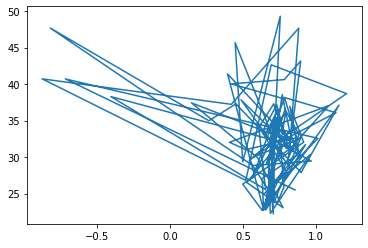

In [10]:
nb_samples = 100
sio2_gen = np.random.random_sample(nb_samples)

reminder = 1.0 - sio2_gen

R_MAl = np.random.random_sample(nb_samples)*(1.0-0.4) + 0.4 # ratio of alkalis to Al

R_XK = np.random.random_sample(nb_samples) # ratio K/(K+Na)

al2o3_gen = (1.0 - R_MAl)*reminder

na2o_gen = (R_MAl*reminder)*(1.0-R_XK)
k2o_gen = (R_MAl*reminder)*(R_XK)

X_gen = pd.DataFrame()
X_gen["sio2"] = sio2_gen
X_gen["al2o3"] = al2o3_gen
X_gen["na2o"] = na2o_gen
X_gen["k2o"] = k2o_gen
X_rec = X_gen.copy()
X_gen = torch.Tensor(X_gen.values).to(device)

Cpconf = neuralmodel.ap_calc(X_gen) + neuralmodel.b_calc(X_gen)* neuralmodel.tg(X_gen)

Cp_S = Cpconf/neuralmodel.sctg(X_gen)



# train-test split
#X_train, X_valid = model_selection.train_test_split(X_gen, test_size=0.30, random_state=42)]

plt.plot(Cp_S.cpu().detach().numpy(),neuralmodel.fragility(X_gen).cpu().detach().numpy())
    
    
    
#    y_entro_train.cpu().detach().numpy(),neuralmodel.sctg(x_entro_train).cpu().detach().numpy(),"ks")

(array([ 2.,  1.,  0.,  5.,  6., 10., 20., 26., 16., 14.]),
 array([-3.3391662, -3.2102168, -3.0812674, -2.9523177, -2.8233683,
        -2.694419 , -2.5654695, -2.43652  , -2.3075705, -2.178621 ,
        -2.0496716], dtype=float32),
 <a list of 10 Patch objects>)

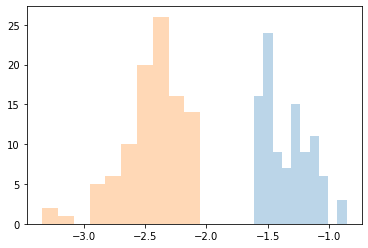

In [11]:
plt.hist(neuralmodel.a_am(X_gen).cpu().detach().numpy(),alpha=0.3)
plt.hist(neuralmodel.ae(X_gen).cpu().detach().numpy(),alpha=0.3)

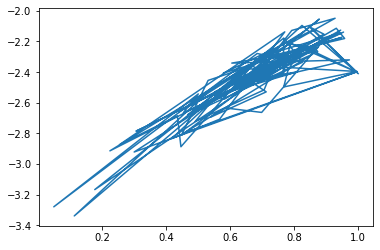

In [12]:
plt.plot(X_rec.sio2+X_rec.al2o3,neuralmodel.ae(X_gen).cpu().detach().numpy())

In [0]:
neuralmodel.ae

Parameter containing:
tensor([-1.7462], device='cuda:0', requires_grad=True)